In [15]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'


In [2]:
df = pd.read_csv("data_aq_ambig.csv")

# Keep only the columns we need
df = df[["interaction_description", "output"]].copy()
df["output"] = df["output"].astype(int)

print("Total samples:", len(df))
print("\nLabel distribution:")
print(df["output"].value_counts())
print("\nSample entries:")
df.head(5)


Total samples: 2505

Label distribution:
output
0    1477
1    1028
Name: count, dtype: int64

Sample entries:


,interaction_description,output
0,Phosphorylated on Tyr residues by TNFRSF14 and...,1
1,"On EGF stimulation, phosphorylated on Tyr-105 ...",0
2,Acetylation at Lys-667 is required for JAK2-me...,0
3,Tyrosine phosphorylated upon IL12 and IFN-alph...,0
4,Tyrosine phosphorylated in response to signali...,1


In [3]:
# First split off the test set (10%)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    random_state=42,
    stratify=df["output"],
)

# Then split train/validation from the remaining 90%
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.111,
    random_state=42,
    stratify=train_val_df["output"],
)
# 0.111 of 90% ≈ 10% of total

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain label distribution:")
print(train_df["output"].value_counts())


Train size: 2003
Validation size: 251
Test size: 251

Train label distribution:
output
0    1181
1     822
Name: count, dtype: int64


In [4]:
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Test it on one example
sample = df["interaction_description"].iloc[0]
tokens = tokenizer(sample, truncation=True, max_length=512)
print("Sample text:", sample[:80], "...")
print("Number of tokens:", len(tokens["input_ids"]))


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Sample text: Phosphorylated on Tyr residues by TNFRSF14 and by antigen receptors cross-linkin ...
Number of tokens: 28


In [5]:
def tokenize(examples):
    return tokenizer(
        examples["interaction_description"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )


# Convert pandas DataFrames to HuggingFace Dataset objects
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Rename label column to what HuggingFace Trainer expects
train_dataset = train_dataset.rename_column("output", "labels")
val_dataset = val_dataset.rename_column("output", "labels")
test_dataset = test_dataset.rename_column("output", "labels")

# Tell the dataset to return PyTorch tensors
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

print("Tokenization complete.")
print("Train dataset features:", train_dataset.features)


Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/251 [00:00<?, ? examples/s]

Map:   0%|          | 0/251 [00:00<?, ? examples/s]

Tokenization complete.
Train dataset features: {'interaction_description': Value('large_string'), 'labels': Value('int64'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}


In [7]:
# Calculate class weights to penalize missing the minority class (1s)
n_neg = (train_df["output"] == 0).sum()
n_pos = (train_df["output"] == 1).sum()
total = n_neg + n_pos

weight_neg = total / (2 * n_neg)
weight_pos = total / (2 * n_pos)
class_weights = torch.tensor([weight_neg, weight_pos], dtype=torch.float)

print(f"Class weight for 0 (no evidence): {weight_neg:.3f}")
print(f"Class weight for 1 (phosphorylation): {weight_pos:.3f}")


# Custom Trainer that uses weighted loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


# Metrics function called after each epoch on the validation set
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }


Class weight for 0 (no evidence): 0.848
Class weight for 1 (phosphorylation): 1.218


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

print("Model loaded and moved to:", device)
print("Total parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- 

Model loaded and moved to: mps
Total parameters: 109.483778 M


In [10]:
training_args = TrainingArguments(
    output_dir="./phospho_model",  # Where to save checkpoints
    num_train_epochs=5,  # Train for 5 full passes over the data
    per_device_train_batch_size=16,  # 16 examples per training step
    per_device_eval_batch_size=32,  # 32 examples per evaluation step
    learning_rate=2e-5,  # Standard fine-tuning learning rate for BERT
    warmup_ratio=0.1,  # Gradually ramp up LR for first 10% of steps
    weight_decay=0.01,  # Regularization to prevent overfitting
    eval_strategy="epoch",  # Evaluate on validation set after each epoch
    save_strategy="epoch",  # Save a checkpoint after each epoch
    load_best_model_at_end=True,  # Auto-load the best checkpoint when done
    metric_for_best_model="f1",  # Use F1 to decide what "best" means
    logging_dir="./logs",
    logging_steps=10,
)

print("Training configuration ready.")


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Training configuration ready.


In [11]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

print("Starting training...")
trainer.train()
print("Training complete.")


Starting training...


/opt/miniconda3/envs/ucsf/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.529175,0.503040,0.729084,0.750000,0.603550,0.990291
2,0.468314,0.498411,0.717131,0.741818,0.593023,0.990291
3,0.284095,0.564595,0.760956,0.772727,0.633540,0.990291
4,0.194769,0.578126,0.760956,0.752066,0.654676,0.883495
5,0.199779,0.662684,0.749004,0.749004,0.635135,0.912621


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/ucsf/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/ucsf/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/ucsf/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/ucsf/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Training complete.


Evaluating on held-out test set...



/opt/miniconda3/envs/ucsf/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


                     precision    recall  f1-score   support

    No Evidence (0)       0.95      0.71      0.81       148
Phosphorylation (1)       0.70      0.95      0.80       103

           accuracy                           0.81       251
          macro avg       0.82      0.83      0.81       251
       weighted avg       0.85      0.81      0.81       251



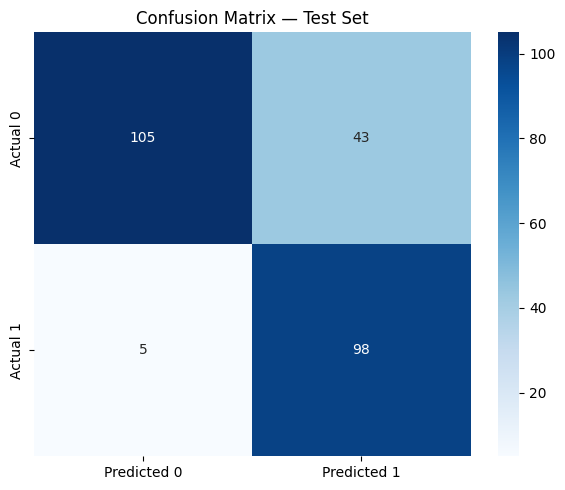

In [ ]:
print("Evaluating on held-out test set...\n")
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print(
    classification_report(
        labels, preds, target_names=["No Evidence (0)", "Phosphorylation (1)"]
    ),
)

# Confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()


In [13]:
trainer.save_model("./phospho_model_final")
tokenizer.save_pretrained("./phospho_model_final")
print("Model saved to ./phospho_model_final")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to ./phospho_model_final


In [16]:
def predict(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True,
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    pred = np.argmax(probs)
    label = "Phosphorylation Evidence" if pred == 1 else "No Evidence"
    print(f"Prediction: {label}")
    print(f"Confidence: {probs[pred] * 100:.1f}%")
    print(f"  P(no evidence): {probs[0] * 100:.1f}%")
    print(f"  P(phosphorylation): {probs[1] * 100:.1f}%")


# Try some examples
predict("Phosphorylated by TBK1 at Ser-172, which activates the kinase")
predict("Phosphorylated on tyrosine residues")
predict("May be involved in signal transduction")


Prediction: Phosphorylation Evidence
Confidence: 88.9%
  P(no evidence): 11.1%
  P(phosphorylation): 88.9%
Prediction: No Evidence
Confidence: 99.5%
  P(no evidence): 99.5%
  P(phosphorylation): 0.5%
Prediction: No Evidence
Confidence: 98.8%
  P(no evidence): 98.8%
  P(phosphorylation): 1.2%
